# A fit-less approach to the elasticity of the handles in optical tweezers experiments

This Jupyter Notebook is a companion to the paper A. Mossa and C. Cecconi, "A fit-less approach to the elasticity of the handles in optical tweezers experiments", 2021 submitted.

It contains the data and the code used to generate the figures in the paper. It is released under MIT License (see the copyright notice at the bottom of the document).

## Figure 2: Typical first trace from 4-MBP pulling experiment

First, we need to read data into our program. Let's reproduce Fig. 2 from the paper.

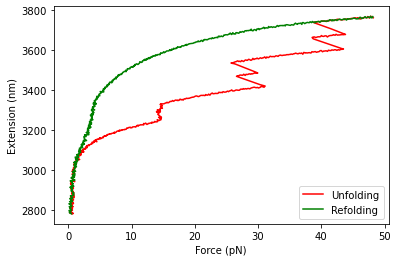

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def readtrace(filename):
    # read an experimental trace from the file where it is stored
    # note that the format is first the force (in pN), then the extension (in nm)  
    fv = []; xv = []
    with open(filename,"r") as infile:
        for line in infile:
            words = line.split()
            fv.append(float(words[0]))
            xv.append(float(words[1]))
    return np.array(fv), np.array(xv)

(fUnf, xUnf) = readtrace("U2.txt")      # read the unfolding trace 
(fRef, xRef) = readtrace("R2.txt")      # read the refolding trace

plt.plot(fUnf,xUnf,'r-',label='Unfolding')
plt.plot(fRef,xRef,'g-',label='Refolding')
plt.legend(loc='lower right')
plt.xlabel('Force (pN)')
plt.ylabel('Extension (nm)')
plt.show()

## Figure 3: The elastic model and the shifted relaxation curve

Now we need to build the elastic model for the unfolded peptide chain.

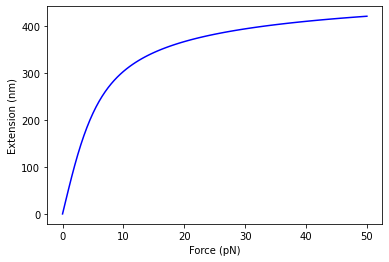

In [2]:
import scipy.optimize
from numpy import sqrt, cbrt, cos, arcsin, pi

def wlcF(z):
    # worm-like chain model: dimensionless force as a function of dimensionless extension
    a = np.array([-0.25, 1.0, -0.5164228, -2.737418, 16.07497, -38.87607, 39.49944, -14.17718])
    b = np.array([z**i for i in range(8)]) 
    return 1/4 * 1/(1-z)**2 + np.dot(a,b)

def wlc0Z(f):
    """ Inversion formula for wlc0 from Appendix A of the paper:
        dimensionless extension as a function of dimensionless force
    """
    f0 = 3/4 + 3/(2*cbrt(2))
    delta = -64*f**3 + 144*f**2 - 108*f + 135
    sml = f <= f0
    lrg = f > f0
    a = np.zeros(len(f)); b = np.zeros(len(f))
    z = np.zeros(len(f)); arg = np.zeros(len(f))
    a[sml] = (delta[sml]+108)/1728
    b[sml] = sqrt(delta[sml]/3)/48
    arg[lrg] = pi/6-arcsin((delta[lrg]+108)/(4*f[lrg]-3)**3)/3
    z[sml] = (4*f[sml]+9)/12 + cbrt(-a[sml]+b[sml]) + cbrt(-a[sml]-b[sml])
    z[lrg] = (4*f[lrg]+9)/12 - (4*f[lrg]-3)/6*cos(arg[lrg])
    return z

class func:
    def __init__(self,f):
        self.f = f
    def value(self,z):
        f = self.f
        return wlcF(z)-f

def wlcZ(f):
    # worm-like chain model: dimensionless extension as a function of dimensionless force 
    tiny = 1.0E-9
    res = np.zeros(len(f))
    res[f > tiny] = scipy.optimize.fsolve(func(f[f>tiny]).value,wlc0Z(f[f>tiny]))
    return res 
    
kBT = (24.0+273.15)*0.01380649   # pN*nm, thermal energy
lc0 = 0.34                       # nm, contour length contribution of each residue
naC = 279                        # aa, size of a core structure
lcC = naC * lc0                  # nm, contour length of one core structure
naT = 1507                       # aa, size of the whole tetramer construct
lcT = naT * lc0                  # nm, contour length of the whole tetramer construct
lp = 0.65                        # nm, persistence length of the unfolded peptide chain

f = np.linspace(0,50,101)
x = lcT * wlcZ(f*lp/kBT)
plt.plot(f,x,'b-')
plt.xlabel('Force (pN)')
plt.ylabel('Extension (nm)')
plt.show()

Subtract from the refolding trace the contribution due to the unfolded peptide chain. This will get us Fig. 3 in the paper.

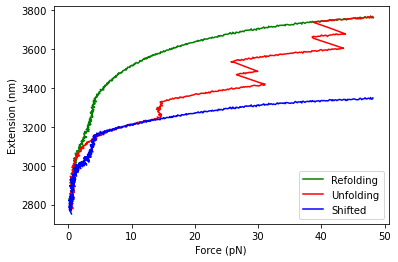

In [3]:
uRef = lcT * wlcZ(fRef*lp/kBT)
sRef = xRef - uRef

plt.plot(fRef,xRef,'g-',label='Refolding')
plt.plot(fUnf,xUnf,'r-',label='Unfolding')
plt.plot(fRef,sRef,'b-',label='Shifted')
plt.legend(loc='lower right')
plt.xlabel('Force (pN)')
plt.ylabel('Extension (nm)')
plt.show()

## Figure 4: Construction of the baseline and the grid

The baseline is built joining the low-force portion of the unfolding trace with the high-force portion of the shifted refolding trace.  

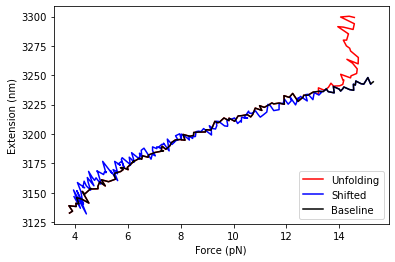

In [4]:
i0 = 267; i1 = 391              # the particular values are fixed by hand 
fBline = np.concatenate((fUnf[:i0],fRef[i1:]))
xBline = np.concatenate((xUnf[:i0],sRef[i1:]))

plt.plot(fUnf[180:300],xUnf[180:300],'r-',label='Unfolding')
plt.plot(fRef[245:410],sRef[245:410],'b-',label='Shifted')
plt.plot(fBline[180:287],xBline[180:287],'k-',label='Baseline')
plt.legend(loc='lower right')
plt.xlabel('Force (pN)')
plt.ylabel('Extension (nm)')
plt.show()

The baseline can be smoothed with a running average filter. 

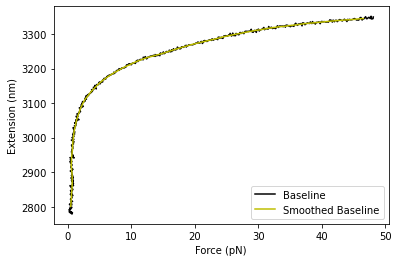

In [5]:
nf = 11        # number of points to be used in the filter
fSB = np.array([np.mean(fBline[i-nf:i+nf]) for i in range(nf,len(fBline)-nf)])
xSB = np.array([np.mean(xBline[i-nf:i+nf]) for i in range(nf,len(xBline)-nf)])

plt.plot(fBline,xBline,'k-',label='Baseline')
plt.plot(fSB,xSB,'y-',label='Smoothed Baseline')
plt.legend(loc='lower right')
plt.xlabel('Force (pN)')
plt.ylabel('Extension (nm)')
plt.show()

The smoothed baseline is then used to build a grid of reference curves that correspond to the behaviour of the system with *n* unfolded amino acids. (Warning: this may take a few minutes.)

In [6]:
grid = []
for n in range(naT+1):
    grid.append(xSB + n*lc0*wlcZ(fSB*lp/kBT))

And this is Fig. 4.

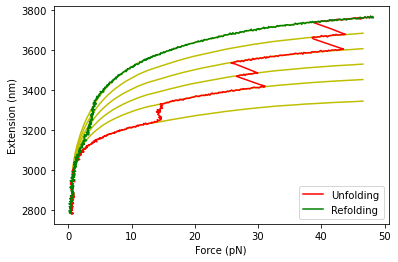

In [7]:
plt.plot(fSB,grid[naT],'y-')
plt.plot(fSB,grid[naT-naC],'y-')
plt.plot(fSB,grid[naT-2*naC],'y-')
plt.plot(fSB,grid[naT-3*naC],'y-')
plt.plot(fSB,grid[naT-4*naC],'y-')
plt.plot(fSB,grid[0],'y-')
plt.plot(fUnf,xUnf,'r-',label='Unfolding')
plt.plot(fRef,xRef,'g-',label='Refolding')
plt.legend(loc='lower right')
plt.xlabel('Force (pN)')
plt.ylabel('Extension (nm)')
plt.show()

## Figure 5: Use of the grid

Now the grid can be used to make sense of other experimental traces belonging to the same dataset. (Fig. 5)

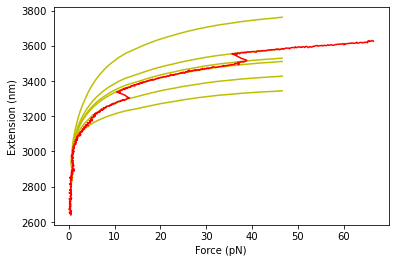

In [8]:
(fU5, xU5) = readtrace("U5.txt")      # read another unfolding trace 

plt.plot(fSB,grid[naT],'y-')
plt.plot(fSB,grid[855],'y-')
plt.plot(fSB,grid[670],'y-')
plt.plot(fSB,grid[602],'y-')
plt.plot(fSB,grid[300],'y-')
plt.plot(fSB,grid[0],'y-')
plt.plot(fU5,xU5,'r-')
plt.xlabel('Force (pN)')
plt.ylabel('Extension (nm)')
plt.show()

## Figure 6: Baseline method applied to monomer MBP pulling experiment

The same baseline & grid construction can be easily modified to analyze an experimental trace obtained with a monomer construct. Let us start with the shifted refolding trace.

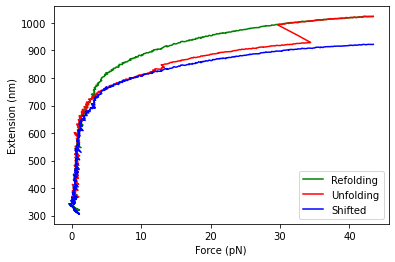

In [9]:
(fUm, xUm) = readtrace("Unf_m.dat")      # unfolding trace, monomer data
(fRm, xRm) = readtrace("Ref_m.dat")      # refolding trace, monomer data

naM = 370         # nr of amino acids in the monomer construct  
lcM = naM * lc0   # nm, contour length of the monomer construct

uRm = lcM * wlcZ(fRm*lp/kBT)
sRm = xRm - uRm                # shifted refolding trace

plt.plot(fRm,xRm,'g-',label='Refolding')
plt.plot(fUm,xUm,'r-',label='Unfolding')
plt.plot(fRm,sRm,'b-',label='Shifted')
plt.legend(loc='lower right')
plt.xlabel('Force (pN)')
plt.ylabel('Extension (nm)')
plt.show()

Now we build the baseline.

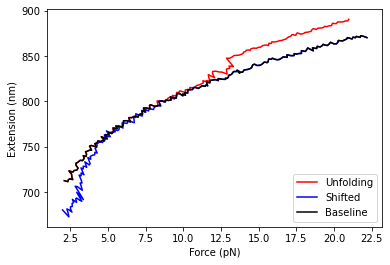

In [10]:
j0 = 244; j1 = 457              # the particular values are fixed by hand 
fBm = np.concatenate((fUm[:j0],fRm[j1:]))
xBm = np.concatenate((xUm[:j0],sRm[j1:]))

plt.plot(fUm[175:350],xUm[175:350],'r-',label='Unfolding')
plt.plot(fRm[360:575],sRm[360:575],'b-',label='Shifted')
plt.plot(fBm[175:362],xBm[175:362],'k-',label='Baseline')
plt.legend(loc='lower right')
plt.xlabel('Force (pN)')
plt.ylabel('Extension (nm)')
plt.show()

Smooth the baseline.

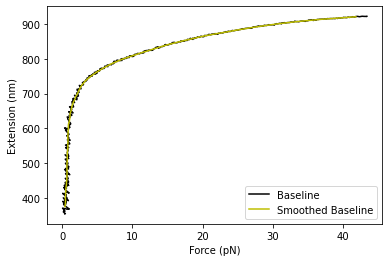

In [11]:
nf = 11        # number of points to be used in the filter
fSm = np.array([np.mean(fBm[i-nf:i+nf]) for i in range(nf,len(fBm)-nf)])
xSm = np.array([np.mean(xBm[i-nf:i+nf]) for i in range(nf,len(xBm)-nf)])

plt.plot(fBm,xBm,'k-',label='Baseline')
plt.plot(fSm,xSm,'y-',label='Smoothed Baseline')
plt.legend(loc='lower right')
plt.xlabel('Force (pN)')
plt.ylabel('Extension (nm)')
plt.show()

Construction of the grid. (Warning: this may take a few minutes.)

In [12]:
gridm = []
for n in range(naM+1):
    gridm.append(xSm + n*lc0*wlcZ(fSm*lp/kBT))

And finally use the grid to read the experimental data. This is the inset of Fig. 6 in the paper.

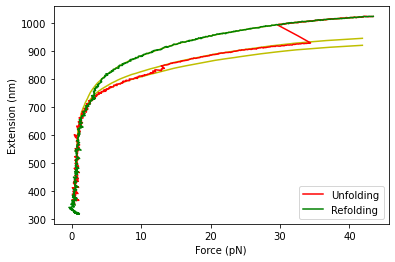

In [13]:
plt.plot(fSm,gridm[naM],'y-')
plt.plot(fSm,gridm[naM-naC],'y-')
plt.plot(fSm,gridm[0],'y-')
plt.plot(fUm,xUm,'r-',label='Unfolding')
plt.plot(fRm,xRm,'g-',label='Refolding')
plt.legend(loc='lower right')
plt.xlabel('Force (pN)')
plt.ylabel('Extension (nm)')
plt.show()

## Figure 7 (not in the paper): Application to a different protein

Yet another example: here we apply the baseline & grid construction to an experimental trace obtained by pulling a mutant of Neuronal Calcium Sensor 1 (NCS-1). It is a 200-residue protein organized in two domains: the 95-residue C domain and the 105-residue N domain. 

First, we read the data and build the shifted relaxation trace.

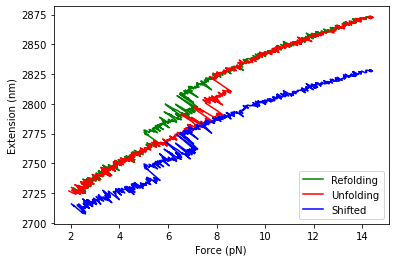

In [14]:
(xUn, fUn) = readtrace("S1.txt")      # unfolding trace, NCS-1 data
(xRn, fRn) = readtrace("R1.txt")      # refolding trace, NCS-1 data

naN = 200         # nr of amino acids in NCS-1 mutant (10 glycine added)  
lcN = naN * lc0   # nm, contour length of the NCS-1 mutant
naP =  95         # nr of amino acids in the C domain
lcP = naP * lc0   # nm, contour length of the C domain

uRn = lcN * wlcZ(fRn*lp/kBT)
sRn = xRn - uRn                # shifted refolding trace

plt.plot(fRn,xRn,'g-',label='Refolding')
plt.plot(fUn,xUn,'r-',label='Unfolding')
plt.plot(fRn,sRn,'b-',label='Shifted')
plt.legend(loc='lower right')
plt.xlabel('Force (pN)')
plt.ylabel('Extension (nm)')
plt.show()

Then we build the baseline

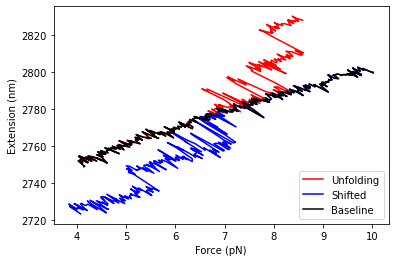

In [24]:
k0 = 280; k1 = 347              # the particular values are fixed by hand 
fBn = np.concatenate((fUn[:k0],fRn[k1:]))
xBn = np.concatenate((xUn[:k0],sRn[k1:]))

plt.plot(fUn[128:454],xUn[128:454],'r-',label='Unfolding')
plt.plot(fRn[105:513],sRn[105:513],'b-',label='Shifted')
plt.plot(fBn[128:447],xBn[128:447],'k-',label='Baseline')
plt.legend(loc='lower right')
plt.xlabel('Force (pN)')
plt.ylabel('Extension (nm)')
plt.show()

Smooth the baseline. These data are a little more noisy than the ones used in the previous examples, so the baseline is a bit more wiggling.

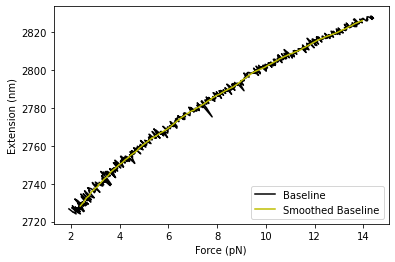

In [25]:
nf = 21        # number of points to be used in the filter
fSn = np.array([np.mean(fBn[i-nf:i+nf]) for i in range(nf,len(fBn)-nf)])
xSn = np.array([np.mean(xBn[i-nf:i+nf]) for i in range(nf,len(xBn)-nf)])

plt.plot(fBn,xBn,'k-',label='Baseline')
plt.plot(fSn,xSn,'y-',label='Smoothed Baseline')
plt.legend(loc='lower right')
plt.xlabel('Force (pN)')
plt.ylabel('Extension (nm)')
plt.show()

Construction of the grid. (Warning: this may take a few minutes.)

In [26]:
gridn = []
for n in range(naN+1):
    gridn.append(xSn + n*lc0*wlcZ(fSn*lp/kBT))

Finally, use the grid to read the data. Here, it shows that the C domain unfolds first: the N domain is 10 residues longer, a difference which would be visible in the graph.

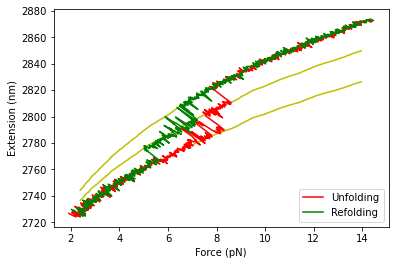

In [27]:
plt.plot(fSn,gridn[naN],'y-')
plt.plot(fSn,gridn[naN-naP],'y-')
plt.plot(fSn,gridn[0],'y-')
plt.plot(fUn,xUn,'r-',label='Unfolding')
plt.plot(fRn,xRn,'g-',label='Refolding')
plt.legend(loc='lower right')
plt.xlabel('Force (pN)')
plt.ylabel('Extension (nm)')
plt.show()

Copyright (c) 2021 Alessandro Mossa

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.